In [13]:
%pip install srai[all] seaborn lonboard optuna optuna-integration[lightgbm] lightgbm datasets

/root/development/srai-tutorial/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


# Prepare Airbnb dataset

Data from: https://zenodo.org/records/4446043#.ZEV8d-zMI-R

In [1]:
import warnings

import geopandas as gpd
import lightgbm as lgb
import lonboard.basemap
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from datasets import load_dataset
from h3 import latlng_to_cell
from lonboard import Map, ScatterplotLayer
from lonboard.colormap import apply_continuous_cmap
from optuna.integration import LightGBMPruningCallback
from optuna.visualization import (
    plot_contour,
    plot_intermediate_values,
    plot_optimization_history,
    plot_param_importances,
)
from quackosm._osm_tags_filters import merge_osm_tags_filter
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from srai.embedders import (
    ContextualCountEmbedder,
    CountEmbedder,
    Hex2VecEmbedder,
)
from srai.h3 import h3_to_geoseries, ring_buffer_h3_regions_gdf
from srai.joiners import IntersectionJoiner
from srai.loaders import OSMPbfLoader
from srai.loaders.osm_loaders.filters import GEOFABRIK_LAYERS
from srai.neighbourhoods import H3Neighbourhood
from srai.regionalizers import H3Regionalizer


In [2]:
ds = load_dataset("kraina/airbnb", "all").filter(
    lambda listing: listing["city"] == "Paris"
)
raw_data = ds["train"].to_pandas()

listings_gdf = gpd.GeoDataFrame(
    raw_data, geometry=gpd.points_from_xy(raw_data.lng, raw_data.lat), crs="EPSG:4326"
)
listings_gdf

,_id,city,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,day_type,geometry
0,16140,Paris,296.159940,Private room,False,True,2.0,True,0,0,...,0.699821,0.193709,518.478947,25.239380,1218.662228,71.608028,2.35385,48.86282,weekdays,POINT (2.35385 48.86282)
1,16141,Paris,288.237487,Private room,False,True,2.0,True,0,0,...,2.100005,0.107221,873.216962,42.507907,1000.543327,58.791463,2.32436,48.85902,weekdays,POINT (2.32436 48.85902)
2,16142,Paris,211.343089,Private room,False,True,2.0,False,0,0,...,3.302325,0.234724,444.556077,21.640840,902.854467,53.051310,2.31714,48.87475,weekdays,POINT (2.31714 48.87475)
3,16143,Paris,298.956100,Entire home/apt,False,False,2.0,False,0,1,...,0.547567,0.195997,542.142014,26.391291,1199.184166,70.463506,2.35600,48.86100,weekdays,POINT (2.356 48.861)
4,16144,Paris,247.926181,Entire home/apt,False,False,4.0,False,0,0,...,1.197921,0.103573,406.928958,19.809165,1070.775497,62.918272,2.35915,48.86648,weekdays,POINT (2.35915 48.86648)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6683,45368,Paris,295.460900,Entire home/apt,False,False,4.0,False,0,0,...,3.660389,0.168146,209.752453,10.199228,540.326583,24.926525,2.38051,48.88393,weekends,POINT (2.38051 48.88393)
6684,45369,Paris,232.081275,Entire home/apt,False,False,4.0,False,0,0,...,3.558813,0.154703,185.486701,9.019304,474.351813,21.882955,2.40050,48.85093,weekends,POINT (2.4005 48.85093)
6685,45370,Paris,223.925809,Entire home/apt,False,False,2.0,False,1,0,...,4.205205,0.253029,172.658919,8.395552,406.585935,18.756757,2.40100,48.87700,weekends,POINT (2.401 48.877)
6686,45371,Paris,200.857489,Entire home/apt,False,False,2.0,True,0,0,...,2.891214,0.240674,235.167925,11.435057,602.451672,27.792500,2.38200,48.87400,weekends,POINT (2.382 48.874)


In [3]:
target_column = "realSum"
geometry_column = "geometry"
feature_columns = [
    "person_capacity",
    "cleanliness_rating",
    "guest_satisfaction_overall",
    "bedrooms",
    "room_type",
]
reduced_columns = [
    target_column,
    *feature_columns,
    geometry_column,
]
listings_gdf = listings_gdf[reduced_columns]
listings_gdf

,realSum,person_capacity,cleanliness_rating,guest_satisfaction_overall,bedrooms,room_type,geometry
0,296.159940,2.0,10.0,97.0,1,Private room,POINT (2.35385 48.86282)
1,288.237487,2.0,10.0,97.0,1,Private room,POINT (2.32436 48.85902)
2,211.343089,2.0,10.0,94.0,1,Private room,POINT (2.31714 48.87475)
3,298.956100,2.0,9.0,91.0,1,Entire home/apt,POINT (2.356 48.861)
4,247.926181,4.0,7.0,82.0,1,Entire home/apt,POINT (2.35915 48.86648)
...,...,...,...,...,...,...,...
6683,295.460900,4.0,9.0,80.0,1,Entire home/apt,POINT (2.38051 48.88393)
6684,232.081275,4.0,10.0,98.0,1,Entire home/apt,POINT (2.4005 48.85093)
6685,223.925809,2.0,9.0,89.0,1,Entire home/apt,POINT (2.401 48.877)
6686,200.857489,2.0,9.0,93.0,1,Entire home/apt,POINT (2.382 48.874)


In [4]:
categorical_columns = ["room_type"]

for col in categorical_columns:
    listings_gdf = pd.concat(
        [listings_gdf, pd.get_dummies(listings_gdf[col], prefix=col)], axis=1
    ).drop(col, axis=1)

In [5]:
listings_gdf.iloc[1].to_dict()

{'realSum': 288.23748718426697,
 'person_capacity': 2.0,
 'cleanliness_rating': 10.0,
 'guest_satisfaction_overall': 97.0,
 'bedrooms': 1,
 'geometry': <POINT (2.324 48.859)>,
 'room_type_Entire home/apt': False,
 'room_type_Private room': True,
 'room_type_Shared room': False}

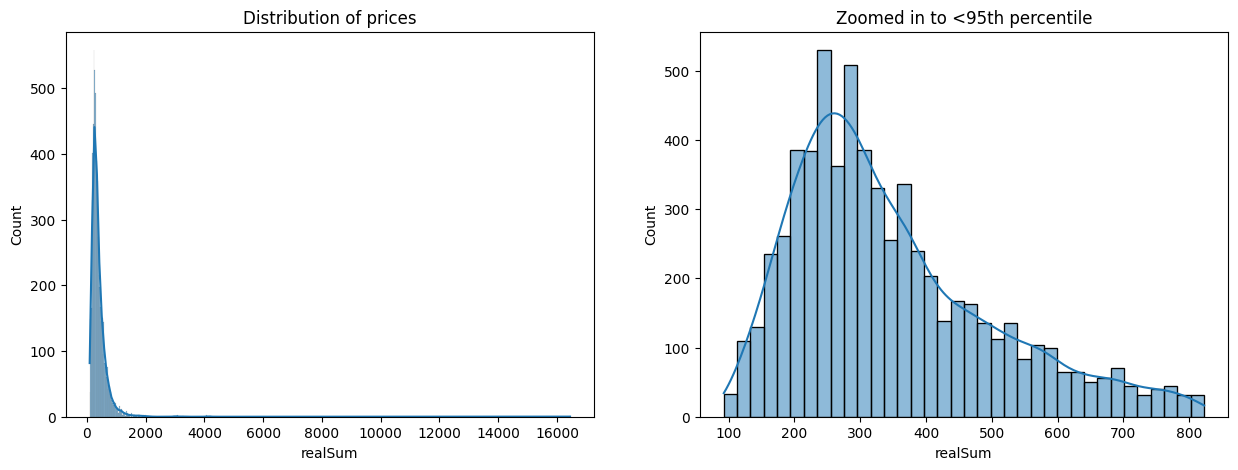

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(listings_gdf, x=target_column, kde=True, ax=ax1)
sns.histplot(
    listings_gdf[
        listings_gdf[target_column] <= listings_gdf[target_column].quantile(0.95)
    ],
    x=target_column,
    kde=True,
    ax=ax2,
)

ax1.set_title("Distribution of prices")
ax2.set_title("Zoomed in to <95th percentile")

plt.show()

In [7]:
filtered_listings_gdf = listings_gdf[
    listings_gdf[target_column] <= listings_gdf[target_column].quantile(0.95)
][[geometry_column, target_column]]

layer = ScatterplotLayer.from_geopandas(
    filtered_listings_gdf,
    get_fill_color=apply_continuous_cmap(
        filtered_listings_gdf[target_column]
        / filtered_listings_gdf[target_column].max(),
        mpl.colormaps["RdYlBu_r"],
        alpha=0.4,
    ),
    radius_units="meters",
    radius_min_pixels=1,
    get_radius=filtered_listings_gdf[target_column] / 10,
)

m = Map(
    layer, _height=800, basemap_style=lonboard.basemap.CartoBasemap.DarkMatterNoLabels
)

m

Map(basemap_style=<CartoBasemap.DarkMatterNoLabels: 'https://basemaps.cartocdn.com/gl/dark-matter-nolabels-gl-…

In [8]:
SPLITTING_H3_RESOLUTION = 8
h3_splitting_column = "h3_splitting"

listings_gdf[h3_splitting_column] = listings_gdf[geometry_column].apply(
    lambda pt: latlng_to_cell(pt.y, pt.x, SPLITTING_H3_RESOLUTION)
)
listings_gdf

,realSum,person_capacity,cleanliness_rating,guest_satisfaction_overall,bedrooms,geometry,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,h3_splitting
0,296.159940,2.0,10.0,97.0,1,POINT (2.35385 48.86282),False,True,False,881fb46621fffff
1,288.237487,2.0,10.0,97.0,1,POINT (2.32436 48.85902),False,True,False,881fb46751fffff
2,211.343089,2.0,10.0,94.0,1,POINT (2.31714 48.87475),False,True,False,881fb475b3fffff
3,298.956100,2.0,9.0,91.0,1,POINT (2.356 48.861),True,False,False,881fb46621fffff
4,247.926181,4.0,7.0,82.0,1,POINT (2.35915 48.86648),True,False,False,881fb46629fffff
...,...,...,...,...,...,...,...,...,...,...
6683,295.460900,4.0,9.0,80.0,1,POINT (2.38051 48.88393),True,False,False,881fb4660bfffff
6684,232.081275,4.0,10.0,98.0,1,POINT (2.4005 48.85093),True,False,False,881fb46459fffff
6685,223.925809,2.0,9.0,89.0,1,POINT (2.401 48.877),True,False,False,881fb46611fffff
6686,200.857489,2.0,9.0,93.0,1,POINT (2.382 48.874),True,False,False,881fb46603fffff


In [18]:
listing_statistics_per_h3 = listings_gdf.reset_index().groupby(h3_splitting_column).agg(
    {"index": "count", "realSum": "mean"}
).rename(columns={"index": "listings", "realSum": "avg_price"})
listing_statistics_per_h3["quantile"] = pd.qcut(
    listing_statistics_per_h3["avg_price"], 5, labels=False
)
listing_statistics_per_h3

,listings,avg_price,quantile
h3_splitting,,,
881fb460d9fffff,1,188.973809,0
881fb46283fffff,6,459.502284,3
881fb46291fffff,19,345.338016,2
881fb46293fffff,40,423.344440,3
881fb46295fffff,26,428.395004,3
...,...,...,...
881fb475b5fffff,83,804.583793,4
881fb475b7fffff,37,639.508229,4
881fb475b9fffff,45,473.224180,4


In [ ]:
def split_h3_cells(ratio=0.2, tolerance=1e-2, random_state=42):
    bucket_1 = []
    bucket_2 = []

    for quantile in listing_statistics_per_h3["quantile"].unique():
        _sub_bucket_1 = []
        _sub_bucket_2 = []
        current_listings = listing_statistics_per_h3[
            listing_statistics_per_h3["quantile"] == quantile
        ].sample(
            frac=1, random_state=random_state
        )

        for index, row in current_listings.iterrows():
            current_bucket_2_sum = sum(t[1] for t in _sub_bucket_2)
            current_ratio = current_bucket_2_sum / current_listings["listings"].sum()

            if current_ratio > ratio:
                _sub_bucket_1.append((index, row["listings"]))
                continue

            next_ratio = (current_bucket_2_sum + row["listings"]) / current_listings[
                "listings"
            ].sum()
            if next_ratio > (ratio * (1 + tolerance)):
                _sub_bucket_1.append((index, row["listings"]))
                continue

            if len(_sub_bucket_1) > len(_sub_bucket_2):
                _sub_bucket_2.append((index, row["listings"]))
            else:
                _sub_bucket_1.append((index, row["listings"]))

        bucket_1.extend(_sub_bucket_1)
        bucket_2.extend(_sub_bucket_2)

    bucket_2_total_listings = sum(t[1] for t in bucket_2)
    total_listings = listing_statistics_per_h3["listings"].sum()
    print(
        f"Ratio: {(bucket_2_total_listings / total_listings):.3f} (expected: {ratio})"
    )

    h3_bucket_1 = [t[0] for t in bucket_1]
    h3_bucket_2 = [t[0] for t in bucket_2]

    bucket_1_listings = listing_statistics_per_h3.loc[h3_bucket_1]
    bucket_2_listings = listing_statistics_per_h3.loc[h3_bucket_2]

    bucket_1_mean_value = (
        bucket_1_listings["listings"] * bucket_1_listings["avg_price"]
    ).sum() / bucket_1_listings["listings"].sum()
    bucket_2_mean_value = (
        bucket_2_listings["listings"] * bucket_2_listings["avg_price"]
    ).sum() / bucket_2_listings["listings"].sum()

    print(
        f"Mean listing prices: {(bucket_1_mean_value):.3f} / {(bucket_2_mean_value):.3f}"
    )

    return h3_bucket_1, h3_bucket_2


train_h3_cells, test_h3_cells = split_h3_cells(ratio=0.33, random_state=73)

train_listing_ids = listings_gdf[listings_gdf[h3_splitting_column].isin(train_h3_cells)].index
test_listing_ids = listings_gdf[listings_gdf[h3_splitting_column].isin(test_h3_cells)].index
len(train_listing_ids), len(test_listing_ids)

Ratio: 0.316 (expected: 0.33)
Mean listing prices: 392.539 / 392.514


(4577, 2111)

In [ ]:
m = h3_to_geoseries(
    listings_gdf.loc[train_listing_ids, h3_splitting_column].unique()
).explore(tiles="CartoDB Positron", color="royalblue")
h3_to_geoseries(
    listings_gdf.loc[test_listing_ids, h3_splitting_column].unique()
).explore(m=m, color="orange")
filtered_listings_gdf.explore(target_column, m=m)

In [28]:
def find_best_lightgbm_model(
    features, target, previous_best_params=None, n_trials=None, timeout=120
):
    x_train = features.loc[train_listing_ids]
    x_test = features.loc[test_listing_ids]
    y_train = target.loc[train_listing_ids]
    y_test = target.loc[test_listing_ids]

    train_dataset = lgb.Dataset(x_train, label=y_train)
    eval_dataset = lgb.Dataset(x_test, label=y_test)

    # https://github.com/optuna/optuna-examples/blob/main/lightgbm/lightgbm_integration.py
    def objective(trial):
        param = {
            "objective": "regression",
            "metric": ["l1", "l2"],
            "verbosity": -1,
            "boosting_type": "gbdt",
            "feature_pre_filter": False,
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        }

        warnings.filterwarnings(
            "ignore",
            category=optuna.exceptions.ExperimentalWarning,
        )

        pruning_callback = LightGBMPruningCallback(trial, "l1")

        gbm = lgb.train(
            param,
            train_dataset,
            valid_sets=[eval_dataset],
            num_boost_round=200,
            callbacks=[
                pruning_callback,
                lgb.early_stopping(stopping_rounds=50, verbose=False),
            ],
        )

        preds = gbm.predict(x_test, num_iteration=gbm.best_iteration + 1)
        pred_labels = np.rint(preds)

        rmse = root_mean_squared_error(y_test, pred_labels)
        return rmse

    optuna.logging.set_verbosity(optuna.logging.WARNING)

    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(
            n_warmup_steps=5, n_min_trials=5, n_startup_trials=5
        ),
        direction="minimize",
    )

    if previous_best_params is not None:
        study.enqueue_trial(previous_best_params)

    study.optimize(
        objective, n_trials=n_trials, timeout=timeout, show_progress_bar=True
    )

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print(f"  Value: {trial.value}")
    print(f"  Params: {trial.params}")

    # Visualize the optimization history.
    plot_optimization_history(study).show()

    # Visualize the learning curves of the trials.
    plot_intermediate_values(study).show()

    # Visualize hyperparameter relationships.
    plot_contour(study).show()

    # Visualize parameter importances.
    plot_param_importances(study).show()

    gbm = lgb.train(
        trial.params,
        train_dataset,
        valid_sets=[eval_dataset],
        num_boost_round=10_000,
        callbacks=[lgb.early_stopping(stopping_rounds=100)],
    )

    y_pred = gbm.predict(x_test)

    result = dict(
        RMSE=root_mean_squared_error(y_test, y_pred),
        R2=r2_score(y_test, y_pred),
        MAE=mean_absolute_error(y_test, y_pred),
        n_features=features.shape[1],
        y_test=y_test,
        y_pred_test=y_pred,
        y_pred_all=gbm.predict(features),
    )

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    for ax in (ax1, ax2):
        sns.regplot(
            x=y_test,
            y=y_pred,
            scatter_kws=dict(alpha=1, s=2),
            line_kws=dict(color=".2", linestyle="--"),
            ax=ax,
        )
        sns.lineplot(x=[0, y_test.max()], y=[0, y_test.max()], color="red", ax=ax)
        ax.set_xlabel("Actual price")
        ax.set_ylabel("Predicted price")

    q95 = y_test.quantile(0.95)
    ax2.set_xlim(0, q95)
    ax2.set_ylim(0, q95)

    ax1.set_title("Baseline model performance")
    ax2.set_title("Zoomed in to <95th percentile")

    plt.show()

    lgb.plot_importance(gbm, max_num_features=20)
    plt.show()

    print(
        f"RMSE: {result['RMSE']:.2f}, MAE: {result['MAE']:.2f}, R2: {result['R2']:.2f}"
    )

    return result

### Baseline

In [29]:
results = []

In [30]:
features = listings_gdf.drop(
    columns=[target_column, geometry_column, h3_splitting_column]
)
target = listings_gdf[target_column]

features

,person_capacity,cleanliness_rating,guest_satisfaction_overall,bedrooms,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,2.0,10.0,97.0,1,False,True,False
1,2.0,10.0,97.0,1,False,True,False
2,2.0,10.0,94.0,1,False,True,False
3,2.0,9.0,91.0,1,True,False,False
4,4.0,7.0,82.0,1,True,False,False
...,...,...,...,...,...,...,...
6683,4.0,9.0,80.0,1,True,False,False
6684,4.0,10.0,98.0,1,True,False,False
6685,2.0,9.0,89.0,1,True,False,False
6686,2.0,9.0,93.0,1,True,False,False


In [ ]:
optuna_result = find_best_lightgbm_model(features, target, timeout=120)
optuna_result["experiment"] = "baseline"

results.append(optuna_result)

   0%|          | 00:00/02:00

### Count Embedder

In [ ]:
EMBEDDING_H3_RESOLUTION = 10
h3_embedding_column = "h3_embedding"

listings_gdf[h3_embedding_column] = listings_gdf[geometry_column].apply(
    lambda pt: latlng_to_cell(pt.y, pt.x, EMBEDDING_H3_RESOLUTION)
)
listings_gdf

In [ ]:
unique_h3_cells = listings_gdf[h3_embedding_column].unique()
regions_gdf = gpd.GeoDataFrame(
    data=dict(region_id=unique_h3_cells), geometry=h3_to_geoseries(unique_h3_cells)
).set_index("region_id")
regions_gdf

In [ ]:
flat_geofabrik_osm_tags_filter = merge_osm_tags_filter(GEOFABRIK_LAYERS)

In [ ]:
features_gdf = OSMPbfLoader().load(regions_gdf, flat_geofabrik_osm_tags_filter)
features_gdf

In [ ]:
joint = IntersectionJoiner().transform(regions_gdf, features_gdf)
joint

In [ ]:
count_embeddings = CountEmbedder(
    expected_output_features=flat_geofabrik_osm_tags_filter, count_subcategories=True
).transform(regions_gdf, features_gdf, joint)
count_embeddings

In [ ]:
features = listings_gdf.merge(
    count_embeddings.reset_index(),
    left_on=h3_embedding_column,
    right_on=count_embeddings.index.name,
).drop(
    columns=[
        target_column,
        geometry_column,
        h3_splitting_column,
        h3_embedding_column,
        count_embeddings.index.name,
    ]
)
target = listings_gdf[target_column]

features

In [ ]:
optuna_result = find_best_lightgbm_model(features, target, timeout=120)
optuna_result["experiment"] = "count embeddings"

results.append(optuna_result)

### Contextual Count Embedder

In [ ]:
H3_NEIGHBOURHOOD = 5

buffered_regions_gdf = ring_buffer_h3_regions_gdf(
    regions_gdf, distance=H3_NEIGHBOURHOOD
)
buffered_regions_gdf

In [ ]:
features_gdf = OSMPbfLoader().load(buffered_regions_gdf, flat_geofabrik_osm_tags_filter)
features_gdf

In [ ]:
joint = IntersectionJoiner().transform(buffered_regions_gdf, features_gdf)
joint

In [ ]:
context_embeddings = ContextualCountEmbedder(
    count_subcategories=True,
    expected_output_features=flat_geofabrik_osm_tags_filter,
    neighbourhood=H3Neighbourhood(),
    neighbourhood_distance=H3_NEIGHBOURHOOD,
    concatenate_vectors=False,
).transform(buffered_regions_gdf, features_gdf, joint)
context_embeddings

In [ ]:
features = listings_gdf.merge(
    context_embeddings.reset_index(),
    left_on=h3_embedding_column,
    right_on=context_embeddings.index.name,
).drop(
    columns=[
        target_column,
        geometry_column,
        h3_splitting_column,
        h3_embedding_column,
        context_embeddings.index.name,
    ]
)
target = listings_gdf[target_column]

features

In [ ]:
optuna_result = find_best_lightgbm_model(features, target, timeout=120)
optuna_result["experiment"] = "contextual count embeddings"

results.append(optuna_result)

### Hex2Vec Embedder

In [ ]:
features_gdf = OSMPbfLoader().load(buffered_regions_gdf, flat_geofabrik_osm_tags_filter)
joint = IntersectionJoiner().transform(buffered_regions_gdf, features_gdf)
hex2vec_embeddings = Hex2VecEmbedder(
    expected_output_features=flat_geofabrik_osm_tags_filter,
    encoder_sizes=[150, 100, 50, 16],
    count_subcategories=True,
).fit_transform(
    buffered_regions_gdf,
    features_gdf,
    joint,
    neighbourhood=H3Neighbourhood(buffered_regions_gdf),
    batch_size=1024,
    trainer_kwargs=dict(max_epochs=20),
)
features = listings_gdf.merge(
    hex2vec_embeddings.reset_index(),
    left_on=h3_embedding_column,
    right_on=hex2vec_embeddings.index.name,
).drop(
    columns=[
        target_column,
        geometry_column,
        h3_splitting_column,
        h3_embedding_column,
        hex2vec_embeddings.index.name,
    ]
)
target = listings_gdf[target_column]

features

In [ ]:
optuna_result = find_best_lightgbm_model(features, target, timeout=120)
optuna_result["experiment"] = "hex2vec embeddings"

results.append(optuna_result)

### Display results on a map

In [ ]:
aggregated_results = pd.DataFrame(results)[
    ["experiment", "n_features", "RMSE", "R2", "MAE"]
]
aggregated_results

In [ ]:
# results from contextual count embeddings
listings_gdf["prediction"] = results[-2]["y_pred_all"]

# Symmetric mean absolute percentage error
listings_gdf["smape"] = (
    2
    * (listings_gdf[target_column] - listings_gdf["prediction"])
    / (listings_gdf[target_column] + listings_gdf["prediction"])
)

listings_gdf

In [ ]:
filtered_listings_gdf = listings_gdf[
    listings_gdf[target_column] <= listings_gdf[target_column].quantile(0.95)
][[geometry_column, target_column, "prediction"]]

layer = ScatterplotLayer.from_geopandas(
    filtered_listings_gdf,
    get_fill_color=apply_continuous_cmap(
        filtered_listings_gdf["prediction"] / filtered_listings_gdf["prediction"].max(),
        mpl.colormaps["RdYlBu_r"],
        alpha=0.7,
    ),
    radius_units="meters",
    radius_min_pixels=1,
    get_radius=filtered_listings_gdf[target_column] / 10,
)

m = Map(
    layer, _height=800, basemap_style=lonboard.basemap.CartoBasemap.DarkMatterNoLabels
)

m

In [ ]:
filtered_listings_gdf = listings_gdf[
    listings_gdf[target_column] <= listings_gdf[target_column].quantile(0.95)
].copy()

filtered_listings_gdf["normalized_smape"] = (
    filtered_listings_gdf["smape"].apply(
        lambda x, filtered_listings_gdf=filtered_listings_gdf: (
            -x / filtered_listings_gdf["smape"].min()
            if x < 0
            else x / filtered_listings_gdf["smape"].max()
        )
    )
    + 1
) / 2

filtered_listings_gdf["normalized_smape_alpha"] = (
    filtered_listings_gdf["normalized_smape"] - 0.5
).abs() * 2

layer = ScatterplotLayer.from_geopandas(
    filtered_listings_gdf,
    get_fill_color=apply_continuous_cmap(
        filtered_listings_gdf["normalized_smape"],
        mpl.colormaps["bwr_r"],
        alpha=filtered_listings_gdf["normalized_smape_alpha"],
    ),
    radius_units="meters",
    radius_min_pixels=1,
    get_radius=filtered_listings_gdf[target_column] / 10,
)

m = Map(
    layer, _height=800, basemap_style=lonboard.basemap.CartoBasemap.DarkMatterNoLabels
)

m